## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/ecol/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '2'

In [4]:
def load_count_positions_v2(csv_name, csv_path):
    data = []
    gene_names = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = int(float(j))
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][1])
        data[ii] = np.array(data[ii][2:])
    
    return data, gene_names

## Loading up the csv file.

In [5]:
# Load in the count positions data.
data_mutant, names_mutant = load_count_positions_v2(mutation+"_"+samp_num+"_counts.csv",csv_path)
data_control, names_control = load_count_positions_v2("control_"+ samp_num +"_counts.csv",csv_path)

## Loading up the data files 

In [6]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + "Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf"),return_type=Transcript))

In [7]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['transcript_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [8]:
transcripts.clear()

## Choose a gene of interest and observe the smooth and unsmooth array.

In [9]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'gltD'
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(my_gene, 
                                           protein_coding, data_mutant, data_control)

In [10]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

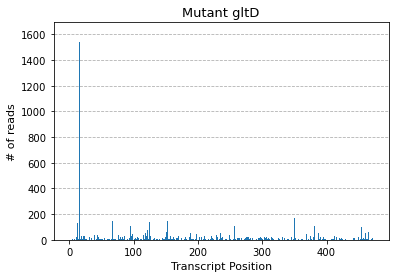

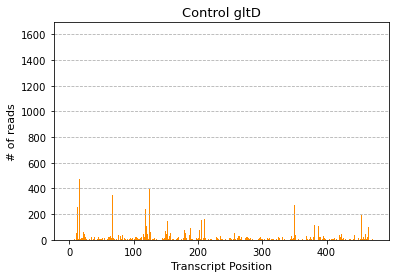

In [11]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant, width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Mutant " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control, color = "darkorange", width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

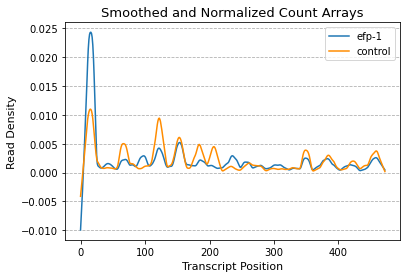

In [12]:
plt.plot(smoothed_vec_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [13]:
ks = max(abs(cumul_m - cumul_c))

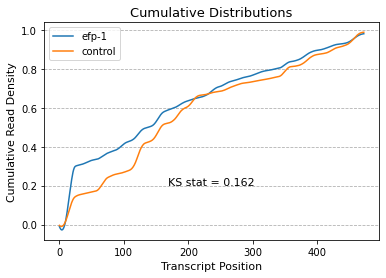

In [14]:
plt.plot(cumul_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(cumul_c, label = "control")
plt.text(168, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_cumulative.pdf')